# Forecasting Indonesia's Youth Unemployment Rate
with feature engineering and optimised setup

### importing libraries and data

In [327]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [328]:
df = pd.read_csv('../data_ind_youth.csv')

In [329]:
# converting to datetime format
df['year_month'] = pd.to_datetime(df['year_month'], format='%Y-%m')
# sorting order chronologically
df = df.sort_values('year_month').reset_index(drop=True)

In [330]:
df_forecast = df.copy()
# setting the time period as index
df_forecast.set_index('year_month', inplace=True)

df_forecast.index = pd.to_datetime(df_forecast.index)
df_forecast.index = pd.period_range(start=df_forecast.index[0], periods=len(df_forecast), freq='2Q')

### feature engineering and setup

In [331]:
from pycaret.time_series import *
import numpy as np

In [ ]:
# feature engineering
# lag 1 = unemployment rate of the previous period
df_forecast['lag_1'] = df_forecast['Unemployment_Rate'].shift(1)
# lag 2 = unemployment rate of two periods ago
df_forecast['lag_2'] = df_forecast['Unemployment_Rate'].shift(2)
# average unemployment rate of the previous 3 periods - smooths short-term fluctuations
df_forecast['rolling_mean_3'] = df_forecast['Unemployment_Rate'].rolling(window=3, closed='left').mean()

# column indicating quarter
df_forecast['quarter'] = df_forecast.index.quarter
# drop dows with missing values caused by shifting and rolling mean
df_forecast.dropna(inplace=True)

In [333]:
df_forecast.head()

,Unemployment_Rate,lag_1,lag_2,rolling_mean_3,quarter
2009Q3,17.142387,18.040630,18.374399,17.879705,3
2010Q1,15.775727,17.142387,18.040630,17.852472,1
2010Q3,15.989462,15.775727,17.142387,16.986248,3
2011Q1,16.851591,15.989462,15.775727,16.302525,1
2011Q3,16.717763,16.851591,15.989462,16.205593,3


In [334]:
# setup
# differences = box-cox transformation, explicitly specifying seasonal periods
exp = setup(
    data=df_forecast,
    target='Unemployment_Rate',
    fh=6,
    session_id=123,
    #transform_target='box-cox',
    seasonal_period=[2, 4]
)

,Description,Value
0,session_id,123
1,Target,Unemployment_Rate
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(31, 5)"
5,Transformed data shape,"(31, 5)"
6,Transformed train set shape,"(25, 5)"
7,Transformed test set shape,"(6, 5)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


### statistics

In [335]:
check_stats()

,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Transformed,Length,,31.0
1,Summary,Statistics,Transformed,# Missing Values,,0.0
2,Summary,Statistics,Transformed,Mean,,14.299465
3,Summary,Statistics,Transformed,Median,,14.186109
4,Summary,Statistics,Transformed,Standard Deviation,,1.57381
5,Summary,Statistics,Transformed,Variance,,2.476878
6,Summary,Statistics,Transformed,Kurtosis,,-1.08518
7,Summary,Statistics,Transformed,Skewness,,0.147363
8,Summary,Statistics,Transformed,# Distinct Values,,31.0
9,White Noise,Ljung-Box,Transformed,Test Statictic,"{'alpha': 0.05, 'K': 24}",68.079361


### model comparisons

In [338]:
best_model = compare_models(exclude='lr_cds_dt') 
# the exclusion of this was purely due to very poor performance on a previous run

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,14:21:53
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
et_cds_dt,Extra Trees w/ Cond. Deseasonalize & Detrending,0.8726,0.9339,1.1416,1.3724,0.0780,0.0817,-0.2018,0.0833
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,0.8839,0.9887,1.1541,1.4532,0.0791,0.0822,-0.2562,0.0400
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,0.8945,0.9805,1.1792,1.4487,0.0824,0.0835,-0.2570,0.0633
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,0.9207,1.0103,1.2113,1.4836,0.0827,0.0869,-0.3235,0.0900
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,0.9207,1.0103,1.2113,1.4836,0.0827,0.0869,-0.3235,0.0700
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,0.9207,1.0103,1.2113,1.4836,0.0827,0.0869,-0.3235,0.0633
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize & Detrending,0.9207,1.0103,1.2113,1.4836,0.0827,0.0869,-0.3235,0.0500
dt_cds_dt,Decision Tree w/ Cond. Deseasonalize & Detrending,0.9411,1.0412,1.2028,1.5100,0.0822,0.0848,-0.3459,0.0367
rf_cds_dt,Random Forest w/ Cond. Deseasonalize & Detrending,0.9533,1.0171,1.2440,1.4882,0.0852,0.0896,-0.3517,0.4367
knn_cds_dt,K Neighbors w/ Cond. Deseasonalize & Detrending,0.9810,1.0219,1.2801,1.4987,0.0880,0.0925,-0.3618,0.0667


diagnostics plot

In [258]:
exp.plot_model(plot="diagnostics", fig_kwargs={"height": 800, "width": 1000})

difference plot

In [259]:
exp.plot_model(
    plot="diff",
    data_kwargs={"lags_list": [[1], [1, 2]], "acf": True, "pacf": True, "periodogram": True},
    fig_kwargs={"height": 800, "width": 1500}
)

STL decomposition

In [260]:
exp.plot_model(plot="decomp_stl", fig_kwargs={"height": 500})

### fine tuning

In [344]:
et_cds_dt = exp.create_model('et_cds_dt')
y_predict_et_cds_dt = exp.predict_model(et_cds_dt)
exp.plot_model(estimator=et_cds_dt)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2012Q3,1.1098,1.1586,1.6967,1.9441,0.1143,0.1170,-0.7658
1,2015Q3,0.2785,0.2630,0.3232,0.3529,0.0234,0.0234,0.8845
2,2018Q3,1.2294,1.3800,1.4051,1.8202,0.0964,0.1048,-0.7242
Mean,NaT,0.8726,0.9339,1.1416,1.3724,0.0780,0.0817,-0.2018
SD,NaT,0.4229,0.4829,0.5909,0.7227,0.0393,0.0415,0.7683


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,ExtraTreesRegressor,0.7282,0.6838,0.8125,0.8958,0.0617,0.0642,0.0590


In [386]:
tuned_et_cds_dt = tune_model(et_cds_dt, n_iter=20, optimize='MASE')
exp.predict_model(tuned_et_cds_dt)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2012Q3,1.1912,1.2073,1.8211,2.0259,0.1218,0.1260,-0.9174
1,2015Q3,0.3432,0.3808,0.3983,0.5110,0.0305,0.0298,0.7579
2,2018Q3,1.1986,1.3362,1.3698,1.7625,0.0939,0.1017,-0.6165
Mean,NaT,0.9110,0.9748,1.1964,1.4331,0.0821,0.0859,-0.2587
SD,NaT,0.4015,0.4233,0.5937,0.6608,0.0382,0.0409,0.7292


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    6.6s finished


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,ExtraTreesRegressor,0.7282,0.6838,0.8125,0.8958,0.0617,0.0642,0.0590


,y_pred
2022Q1,12.2517
2022Q3,13.7780
2023Q1,11.1408
2023Q3,13.3271
2024Q1,11.2102
2024Q3,12.9196


In [342]:
exp.plot_model(estimator=tuned_et_cds_dt)

In [343]:
print(et_cds_dt.get_params())
print(tuned_et_cds_dt.get_params())

{'degree': 1, 'deseasonal_model': 'additive', 'fe_target_rr': [WindowSummarizer(lag_feature={'lag': [2, 1]}, n_jobs=1)], 'regressor': ExtraTreesRegressor(n_jobs=-1, random_state=123), 'sp': 2, 'window_length': 2, 'regressor__bootstrap': False, 'regressor__ccp_alpha': 0.0, 'regressor__criterion': 'squared_error', 'regressor__max_depth': None, 'regressor__max_features': 1.0, 'regressor__max_leaf_nodes': None, 'regressor__max_samples': None, 'regressor__min_impurity_decrease': 0.0, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__min_weight_fraction_leaf': 0.0, 'regressor__monotonic_cst': None, 'regressor__n_estimators': 100, 'regressor__n_jobs': -1, 'regressor__oob_score': False, 'regressor__random_state': 123, 'regressor__verbose': 0, 'regressor__warm_start': False}
{'degree': 1, 'deseasonal_model': 'additive', 'fe_target_rr': [WindowSummarizer(lag_feature={'lag': [2, 1]}, n_jobs=1)], 'regressor': ExtraTreesRegressor(n_jobs=-1, random_state=123), 'sp': 2,

In [345]:
omp_cds_dt= exp.create_model('omp_cds_dt')
y_predict_omp_cds_dt = exp.predict_model(omp_cds_dt)
exp.plot_model(estimator=omp_cds_dt)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2012Q3,1.0984,1.2136,1.6792,2.0366,0.1105,0.1149,-0.9377
1,2015Q3,0.4493,0.5113,0.5214,0.6861,0.0409,0.0394,0.5635
2,2018Q3,1.1039,1.2411,1.2616,1.6371,0.0859,0.0924,-0.3946
Mean,NaT,0.8839,0.9887,1.1541,1.4532,0.0791,0.0822,-0.2562
SD,NaT,0.3073,0.3377,0.4788,0.5664,0.0288,0.0316,0.6206


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,OrthogonalMatchingPursuit,0.5071,0.4498,0.5658,0.5893,0.0424,0.0431,0.5928


In [387]:
tuned_omp_cds_dt = tune_model(omp_cds_dt, n_iter=20, optimize='MASE')
exp.predict_model(tuned_omp_cds_dt)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,13:54:00
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2012Q3,1.0249,1.1445,1.5668,1.9205,0.1029,0.1071,-0.7231
1,2015Q3,0.4415,0.4903,0.5123,0.6579,0.0399,0.0386,0.5987
2,2018Q3,1.1038,1.2411,1.2616,1.6370,0.0859,0.0924,-0.3946
Mean,NaT,0.8567,0.9586,1.1135,1.4051,0.0762,0.0794,-0.1730
SD,NaT,0.2954,0.3335,0.4431,0.5409,0.0266,0.0294,0.5619


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.8s finished


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,OrthogonalMatchingPursuit,0.5982,0.5652,0.6675,0.7404,0.0520,0.0505,0.3571


,y_pred
2022Q1,13.5132
2022Q3,14.3209
2023Q1,13.2655
2023Q3,14.0416
2024Q1,13.1977
2024Q3,13.9129


In [347]:
exp.plot_model(estimator=tuned_omp_cds_dt)

In [348]:
print(omp_cds_dt.get_params())
print(tuned_omp_cds_dt.get_params())

{'degree': 1, 'deseasonal_model': 'additive', 'fe_target_rr': [WindowSummarizer(lag_feature={'lag': [2, 1]}, n_jobs=1)], 'regressor': OrthogonalMatchingPursuit(), 'sp': 2, 'window_length': 2, 'regressor__fit_intercept': True, 'regressor__n_nonzero_coefs': None, 'regressor__precompute': 'auto', 'regressor__tol': None}
{'degree': 1, 'deseasonal_model': 'additive', 'fe_target_rr': [WindowSummarizer(lag_feature={'lag': [2, 1]}, n_jobs=1)], 'regressor': OrthogonalMatchingPursuit(n_nonzero_coefs=2), 'sp': 4, 'window_length': 2, 'regressor__fit_intercept': True, 'regressor__n_nonzero_coefs': 2, 'regressor__precompute': 'auto', 'regressor__tol': None}


In [349]:
ridge_cds_dt= exp.create_model('ridge_cds_dt')
y_predict_ridge_cds_dt = exp.predict_model(ridge_cds_dt)
exp.plot_model(estimator=ridge_cds_dt)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2012Q3,1.1984,1.2660,1.8321,2.1245,0.1266,0.1256,-1.1086
1,2015Q3,0.4744,0.5133,0.5505,0.6887,0.0420,0.0407,0.5602
2,2018Q3,1.0106,1.1621,1.1550,1.5328,0.0785,0.0843,-0.2227
Mean,NaT,0.8945,0.9805,1.1792,1.4487,0.0824,0.0835,-0.2570
SD,NaT,0.3068,0.3331,0.5235,0.5892,0.0346,0.0347,0.6817


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,Ridge,0.6053,0.5348,0.6754,0.7007,0.0507,0.0517,0.4243


In [388]:
tuned_ridge_cds_dt = tune_model(ridge_cds_dt, n_iter=20, optimize='MASE')
exp.predict_model(tuned_ridge_cds_dt)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2012Q3,1.1847,1.2264,1.8111,2.0581,0.1217,0.1251,-0.9788
1,2015Q3,0.4332,0.4939,0.5026,0.6627,0.0390,0.0377,0.5928
2,2018Q3,1.1051,1.2734,1.2630,1.6797,0.0856,0.0924,-0.4682
Mean,NaT,0.9076,0.9979,1.1922,1.4668,0.0821,0.0851,-0.2847
SD,NaT,0.3371,0.3569,0.5365,0.5892,0.0338,0.0361,0.6546


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.5s finished


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,Ridge,0.6053,0.5348,0.6754,0.7007,0.0507,0.0517,0.4243


,y_pred
2022Q1,12.2644
2022Q3,13.7649
2023Q1,11.8825
2023Q3,13.6045
2024Q1,11.6230
2024Q3,13.5287


In [351]:
exp.plot_model(estimator=tuned_ridge_cds_dt)

In [352]:
print(ridge_cds_dt.get_params())
print(tuned_ridge_cds_dt.get_params())

{'degree': 1, 'deseasonal_model': 'additive', 'fe_target_rr': [WindowSummarizer(lag_feature={'lag': [2, 1]}, n_jobs=1)], 'regressor': Ridge(random_state=123), 'sp': 2, 'window_length': 2, 'regressor__alpha': 1.0, 'regressor__copy_X': True, 'regressor__fit_intercept': True, 'regressor__max_iter': None, 'regressor__positive': False, 'regressor__random_state': 123, 'regressor__solver': 'auto', 'regressor__tol': 0.0001}
{'degree': 1, 'deseasonal_model': 'additive', 'fe_target_rr': [WindowSummarizer(lag_feature={'lag': [2, 1]}, n_jobs=1)], 'regressor': Ridge(random_state=123), 'sp': 2, 'window_length': 2, 'regressor__alpha': 1.0, 'regressor__copy_X': True, 'regressor__fit_intercept': True, 'regressor__max_iter': None, 'regressor__positive': False, 'regressor__random_state': 123, 'regressor__solver': 'auto', 'regressor__tol': 0.0001}


comparisons

In [353]:
exp.compare_models(include=[et_cds_dt, tuned_et_cds_dt, omp_cds_dt, tuned_omp_cds_dt, ridge_cds_dt, tuned_ridge_cds_dt], sort='MASE')

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
3,OrthogonalMatchingPursuit,0.8567,0.9586,1.1135,1.4051,0.0762,0.0794,-0.1730,0.0833
0,ExtraTreesRegressor,0.8726,0.9339,1.1416,1.3724,0.0780,0.0817,-0.2018,0.1033
1,ExtraTreesRegressor,0.8726,0.9339,1.1416,1.3724,0.0780,0.0817,-0.2018,0.1067
2,OrthogonalMatchingPursuit,0.8839,0.9887,1.1541,1.4532,0.0791,0.0822,-0.2562,0.0733
4,Ridge,0.8945,0.9805,1.1792,1.4487,0.0824,0.0835,-0.2570,0.0467
5,Ridge,0.8945,0.9805,1.1792,1.4487,0.0824,0.0835,-0.2570,0.0367


BaseCdsDtForecaster(fe_target_rr=[WindowSummarizer(lag_feature={'lag': [2, 1]},
                                                   n_jobs=1)],
                    regressor=OrthogonalMatchingPursuit(n_nonzero_coefs=2),
                    sp=4, window_length=2)

In [354]:
exp.plot_model([et_cds_dt, tuned_et_cds_dt, omp_cds_dt, tuned_omp_cds_dt, ridge_cds_dt, tuned_ridge_cds_dt], 
               data_kwargs={"labels": ['et_cds_dt', 'tuned_et_cds_dt', 'omp_cds_dt', 'tuned_omp_cds_dt', 'ridge_cds_dt', 'tuned_ridge_cds_dt']})

### finalise model and future forecast

In [ ]:
final_model = exp.finalize_model(tuned_omp_cds_dt)

In [373]:
# future periods to predict
future_periods = pd.period_range(start=df_forecast.index[-1] + 1, periods=6, freq='2Q')  # 5 future periods

# initialising future_df with NaNs for features and target
future_df = pd.DataFrame(index=future_periods, columns=['Unemployment_Rate', 'lag_1', 'lag_2', 'rolling_mean_3', 'quarter'])
future_df[['Unemployment_Rate', 'lag_1', 'lag_2', 'rolling_mean_3', 'quarter']] = np.nan

In [380]:
# defining a function to get value from historical or predicted data
def get_value_for_period(period):
    if period in df_forecast.index:
        value = df_forecast.loc[period, 'Unemployment_Rate']
        print(f"[INFO] Using historical value for {period}: {value}")
        return value
    elif period in future_df.index:
        value = future_df.loc[period, 'Unemployment_Rate']
        if not pd.isna(value):
            print(f"[INFO] Using predicted value for {period}: {value}")
            return value
        else:
            print(f"[WARN] Predicted value for {period} is NaN.")
    else:
        print(f"[WARN] No data found for {period}.")
    return np.nan

In [381]:
future_periods

PeriodIndex(['2025Q1', '2025Q3', '2026Q1', '2026Q3', '2027Q1', '2027Q3'], dtype='period[2Q-DEC]')

In [382]:
# looping over each future period and predict
for period in future_periods:
    # calculating the lag features
    lag_1 = get_value_for_period(period - 1)
    lag_2 = get_value_for_period(period - 2)

    # rolling mean of last 3 values (lags 1, 2, 3)
    last_three_vals = [get_value_for_period(period - i) for i in range(1, 4)]
    rolling_mean_3 = np.nanmean(last_three_vals)  # np.nanmean ignores nan values

    # taking the quarter from the period
    quarter = period.quarter

    # saving features into future_df
    future_df.loc[period, ['lag_1', 'lag_2', 'rolling_mean_3', 'quarter']] = [lag_1, lag_2, rolling_mean_3, quarter]

    # preparing feature vector for prediction
    X_pred = future_df.loc[[period], ['lag_1', 'lag_2', 'rolling_mean_3', 'quarter']].astype(float)

    # checking for NaNs before predicting
    if X_pred.isnull().values.any():
        raise ValueError(f"NaN found in features at period {period}:\n{X_pred}")
    
    #print(X_pred)

    # forecasting future values
    pred_df = predict_model(final_model, X=X_pred, fh=[1])
    pred_value = pred_df['y_pred'].values[0]

    # saving predicted value back to future_df for next iterations
    future_df.loc[period, 'Unemployment_Rate'] = pred_value

    print(f"Predicted Unemployment_Rate at {period}: {pred_value:.3f}")

[INFO] Using historical value for 2024Q3: 12.871909126092456
[INFO] Using historical value for 2024Q1: 12.378460471546267
[INFO] Using historical value for 2024Q3: 12.871909126092456
[INFO] Using historical value for 2024Q1: 12.378460471546267
[INFO] Using historical value for 2023Q3: 14.177533914667926
Predicted Unemployment_Rate at 2025Q1: 11.338
[INFO] Using predicted value for 2025Q1: 11.3382
[INFO] Using historical value for 2024Q3: 12.871909126092456
[INFO] Using predicted value for 2025Q1: 11.3382
[INFO] Using historical value for 2024Q3: 12.871909126092456
[INFO] Using historical value for 2024Q1: 12.378460471546267
Predicted Unemployment_Rate at 2025Q3: 11.806
[INFO] Using predicted value for 2025Q3: 11.8063
[INFO] Using predicted value for 2025Q1: 11.3382
[INFO] Using predicted value for 2025Q3: 11.8063
[INFO] Using predicted value for 2025Q1: 11.3382
[INFO] Using historical value for 2024Q3: 12.871909126092456
Predicted Unemployment_Rate at 2026Q1: 11.806
[INFO] Using predic

In [383]:
# concatenating historical and future predictions into one DataFrame
combined_df = pd.concat([df_forecast[['Unemployment_Rate']], future_df[['Unemployment_Rate']]], axis=0)

# creating a column to indicate whether the value is historical or predicted
combined_df['Type'] = ['Historical'] * len(df_forecast) + ['Predicted'] * len(future_df)

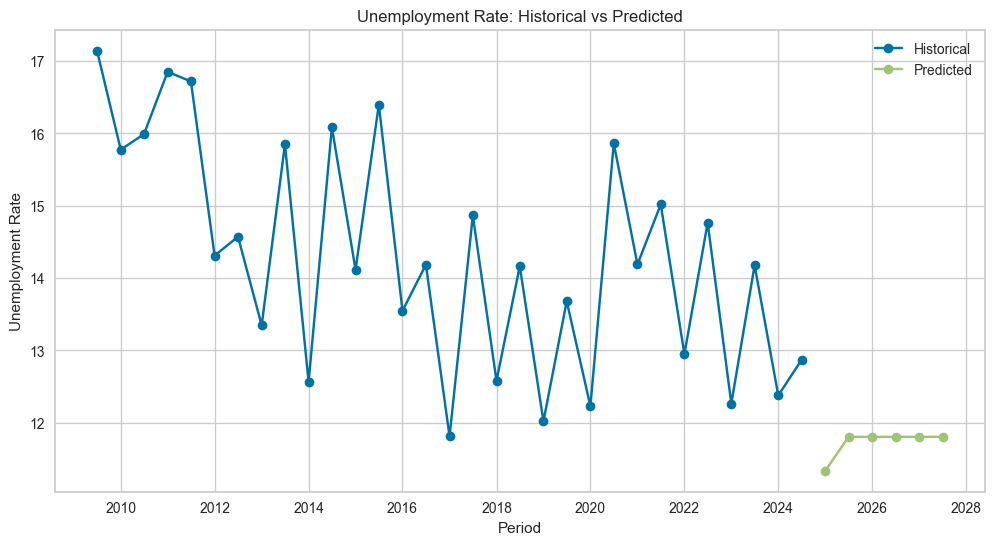

In [384]:
# plotting
plt.figure(figsize=(12,6))

for t_type, group_data in combined_df.groupby('Type'):
    plt.plot(group_data.index.to_timestamp(), group_data['Unemployment_Rate'], 
             marker='o', label=t_type)

plt.title('Unemployment Rate: Historical vs Predicted')
plt.xlabel('Period')
plt.ylabel('Unemployment Rate')
plt.legend()
plt.grid(True)
plt.show()

In [385]:
future_df

,Unemployment_Rate,lag_1,lag_2,rolling_mean_3,quarter
2025Q1,11.3382,12.871909,12.378460,13.142635,1.0
2025Q3,11.8063,11.338200,12.871909,12.196190,3.0
2026Q1,11.8063,11.806300,11.338200,12.005470,1.0
2026Q3,11.8063,11.806300,11.806300,11.650267,3.0
2027Q1,11.8063,11.806300,11.806300,11.806300,1.0
2027Q3,11.8063,11.806300,11.806300,11.806300,3.0
